In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

In [2]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
data_folder_name_1='glove.6B'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name, data_folder_name_1))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

In [3]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

/var/folders/gy/5v8v142s4fz6nz5xwllrz4b40000gn/T/ipykernel_18519/969833379.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


(400000, 100)

In [4]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

In [5]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(model, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [6]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

review = [reverse_word_index.get(i-3, "") for i in train_data[0]]

In [7]:
print('Vocabulary lenght: ',len(word_index))
print('Review example: ',review[:20])
print('Label: ',train_labels[0])

Vocabulary lenght:  88584
Review example:  ['', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you']
Label:  1


In [8]:
# Convert the train and test dataset to strings of words
X_train=[]
for doc in train_data:
    X_train.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

X_test=[]
for doc in test_data:
    X_test.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

In [9]:
print(len(X_train),len(X_test))
print(X_train[0])

25000 25000
 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing an

In [10]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [11]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = train_labels
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = test_labels

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 25000
Numer of samples with no words found: 0 / 25000


In [12]:
print(Xtrain.shape,Xtest.shape)

(25000, 100) (25000, 100)


In [13]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))

train score: 1.0
test score: 0.7606


              precision    recall  f1-score   support

           0    0.76888   0.74520   0.75686     12500
           1    0.75281   0.77600   0.76423     12500

    accuracy                        0.76060     25000
   macro avg    0.76085   0.76060   0.76054     25000
weighted avg    0.76085   0.76060   0.76054     25000



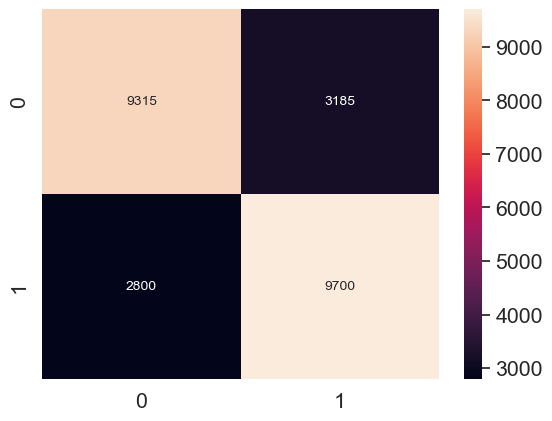

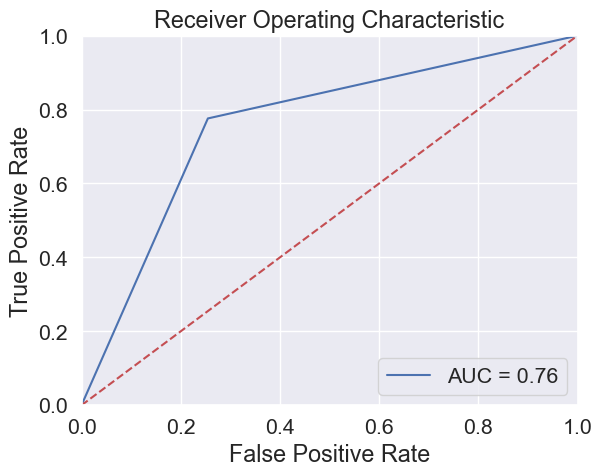

In [15]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)